In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

In [2]:
## Extract parameters.
params = read_csv('stan_results/3pl_summary.tsv', sep='\t', index_col=0)
beta  = params.T.filter(regex='beta\[').T['Mean'].values
alpha = params.T.filter(regex='alpha\[').T['Mean'].values

## Extract DIF. 
dif = read_csv('stan_results/dif.csv')
dif = np.repeat(np.where(dif.fwe2 < 0.05, 1, 0), 2)

## Extract IFS.
ifs = read_csv('stan_results/3pl_ifs.csv')
ifs = np.where(ifs.p >= 0.95, 1, 0)

## Define exclusions.
exclude = np.logical_or(dif, ifs).astype(int)

## 
items = np.arange(exclude.size)
items = items[exclude == 0]
beta  = beta[exclude == 0]
alpha = alpha[exclude == 0]
gamma = 0.25

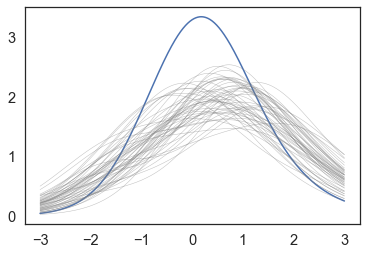

In [29]:
from scipy.stats import norm

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

theta = np.linspace(-3,3,1001)
template = norm(0,1).pdf(theta)

mu = np.outer(theta, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)
q = 1 - p

info = alpha**2 * (q / p) * np.square((p - gamma) / (1 - gamma))

include = []
for _ in range(12):
    
    ## Define index for remaining items.
    ix = np.setdiff1d(np.arange(items.size), include)
    
    ## Compute potential TIF.
    tif = (info[:,include].sum(axis=1) + info[:,ix].T) @ template
    
    ## Identify maximum TIF.
    include.append(ix[np.argmax(tif)])

chosen = np.sort(items[include])
    
plt.plot(theta, info[:,include].sum(axis=1))

for _ in range(50):
    plt.plot(theta, info[:,np.random.choice(np.arange(items.size), 12)].sum(axis=1), 
             lw=0.5, color='0.5', alpha=0.5)

100%|██████████| 1000/1000 [00:07<00:00, 126.94it/s]


<AxesSubplot:ylabel='Count'>

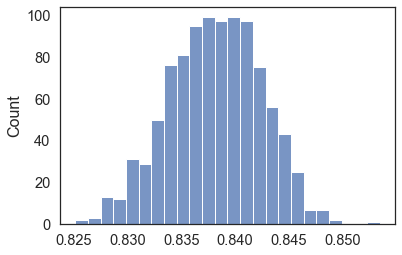

In [22]:
from scipy.stats import spearmanr
from tqdm import tqdm
np.random.seed(47404)

rho = np.zeros(1000)

for n in tqdm(range(rho.size)):

    theta = np.random.normal(0, 1, 5000)
    beta_s = beta[include]
    alpha_s = alpha[include]

    mu = np.outer(theta, alpha_s) - beta_s
    p = gamma + (1 - gamma) * inv_logit(mu)

    scores = np.random.binomial(1, p).sum(axis=1)
    rho[n], _ = spearmanr(theta, scores)
    
sns.histplot(rho)

In [31]:
chosen

array([ 14,  40,  41,  42,  43,  49,  62,  63,  81,  84, 109, 119])